
# **CMP263 - Aprendizagem de Máquina - INF/UFRGS**
#### *Profa. Mariana Recamonde-Mendoza (mrmendoza@inf.ufrgs.br)*
<br>

## Atividade Prática: Pré-processamento de Dados


---
***Observação:*** *Este notebook é disponibilizado aos alunos como complemento às aulas e aos slides preparados pela professora. Desta forma, os principais conceitos são apresentados no material teórico fornecido. O objetivo deste notebook é reforçar os conceitos e demonstrar questões práticas no uso de diferentes algoritmos e estratégias de Aprendizado de Máquina.*

---

**Objetivo deste notebook**: Este notebook demonstra algumas etapas fundamentais de pré-processamento de dados para um problema de classificação usando o dataset de Churn, incluindo transformação de dados (codificação, normalização), imputação de valores e mitigação do problema de desbalanceamento de classes.  Também exemplificamos o treinamento e otimização de modelos (SVM, neste exemplo) com e sem `Pipeline`.



##**Predição de 'churn' de clientes de serviço de telecomunicação**

Os dados que utilizaremos neste notebook se referem a uma empresa de telecomunicações fictícia que forneceu serviços de telefone residencial e Internet para clientes na Califórnia. O conjunto de dados possui informações sobre os serviços para os quais cada cliente se inscreveu (telefone, várias linhas, internet, segurança online, backup online, proteção de dispositivos, suporte técnico e streaming de TV e filmes), informações da conta do cliente (há quanto tempo eles são clientes, contrato, forma de pagamento, cobrança sem papel, cobranças mensais e cobranças totais) e informações demográficas sobre os clientes (sexo, faixa etária, se eles têm parceiros e dependentes). Há, ainda, uma coluna chamada 'churn', que indica os clientes que desistiram do contrato do serviço no último mês. O objetivo da tarefa preditiva é identificar o churn (i.e., saída) de clientes a partir das informações coletadas. Os dados podem ser acessados neste [link](https://www.kaggle.com/datasets/blastchar/telco-customer-churn).

Este é um problema de predição que usualmente apresenta **classes desbalanceadas**. Neste notebook vamos exemplificar algumas tarefas comuns no pré-processamento de dados durante o desenvolvimento de modelos preditivos.

# Carregamento de bibliotecas


Bibliotecas principais: `pandas`, `scikit-learn`, `imblearn`.

In [ ]:
## Carregando as bibliotecas básicas necessárias
# A primeira linha é incluída para gerar os gráficos logo abaixo dos comandos de plot
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

## Carregamento do Dataset

In [ ]:
# Dataset de churn (Telco Customer Churn)
## Carregando os dados
df = pd.read_csv("https://drive.google.com/uc?export=view&id=10VrzI8mA2wPvkNIDaLzv-IglPU-Febtf")#,na_values="NA")

# Visualização inicial
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,NaN,No,Yes,No,1.0,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34.0,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,No,No,No,2.0,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45.0,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,No,No,No,2.0,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Preparação manual


In [ ]:
# Remover as duplicatas
df=df.drop_duplicates(keep='last')

# Remover colunas irrelevantes
df.drop(['customerID'], axis=1, inplace=True)

# Transformar target em binário
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Corrigir tipo da coluna TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Separar features e target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Identificar colunas categóricas e numéricas
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns


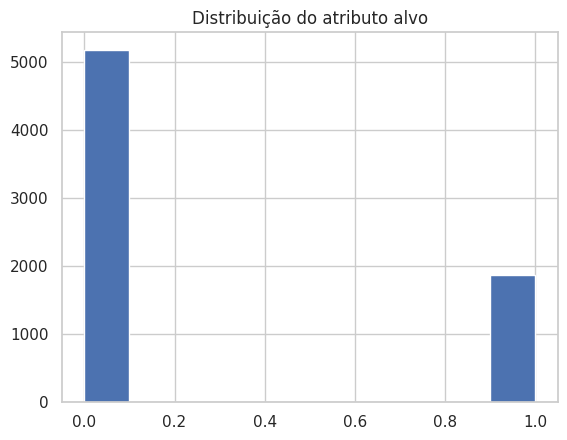

In [ ]:
## Distribuição do atributo alvo
plt.hist(df['Churn'])
plt.title("Distribuição do atributo alvo")
plt.show()

In [ ]:
# Visualização dos dados, separando por atributos numéricos e categóricos
def dist_plot(df,columns,type='boxplot'):
    plt.figure(figsize=(16, 5))
    for indx, var  in enumerate(columns):
        plt.subplot(1, 3, indx+1)
        if (type=='boxplot'):
          g = sns.boxplot(x=var, data=df,showfliers=True)
        else:
          if (type=='histogram'):
            g = sns.histplot(x=var, data=df)
    plt.tight_layout()

def count_plot(df,columns):
    plt.figure(figsize=(20, 12))
    for indx, var  in enumerate(columns):
        plt.subplot(6, 3, indx+1)
        g = sns.countplot(x=var, data=df)
    plt.tight_layout()

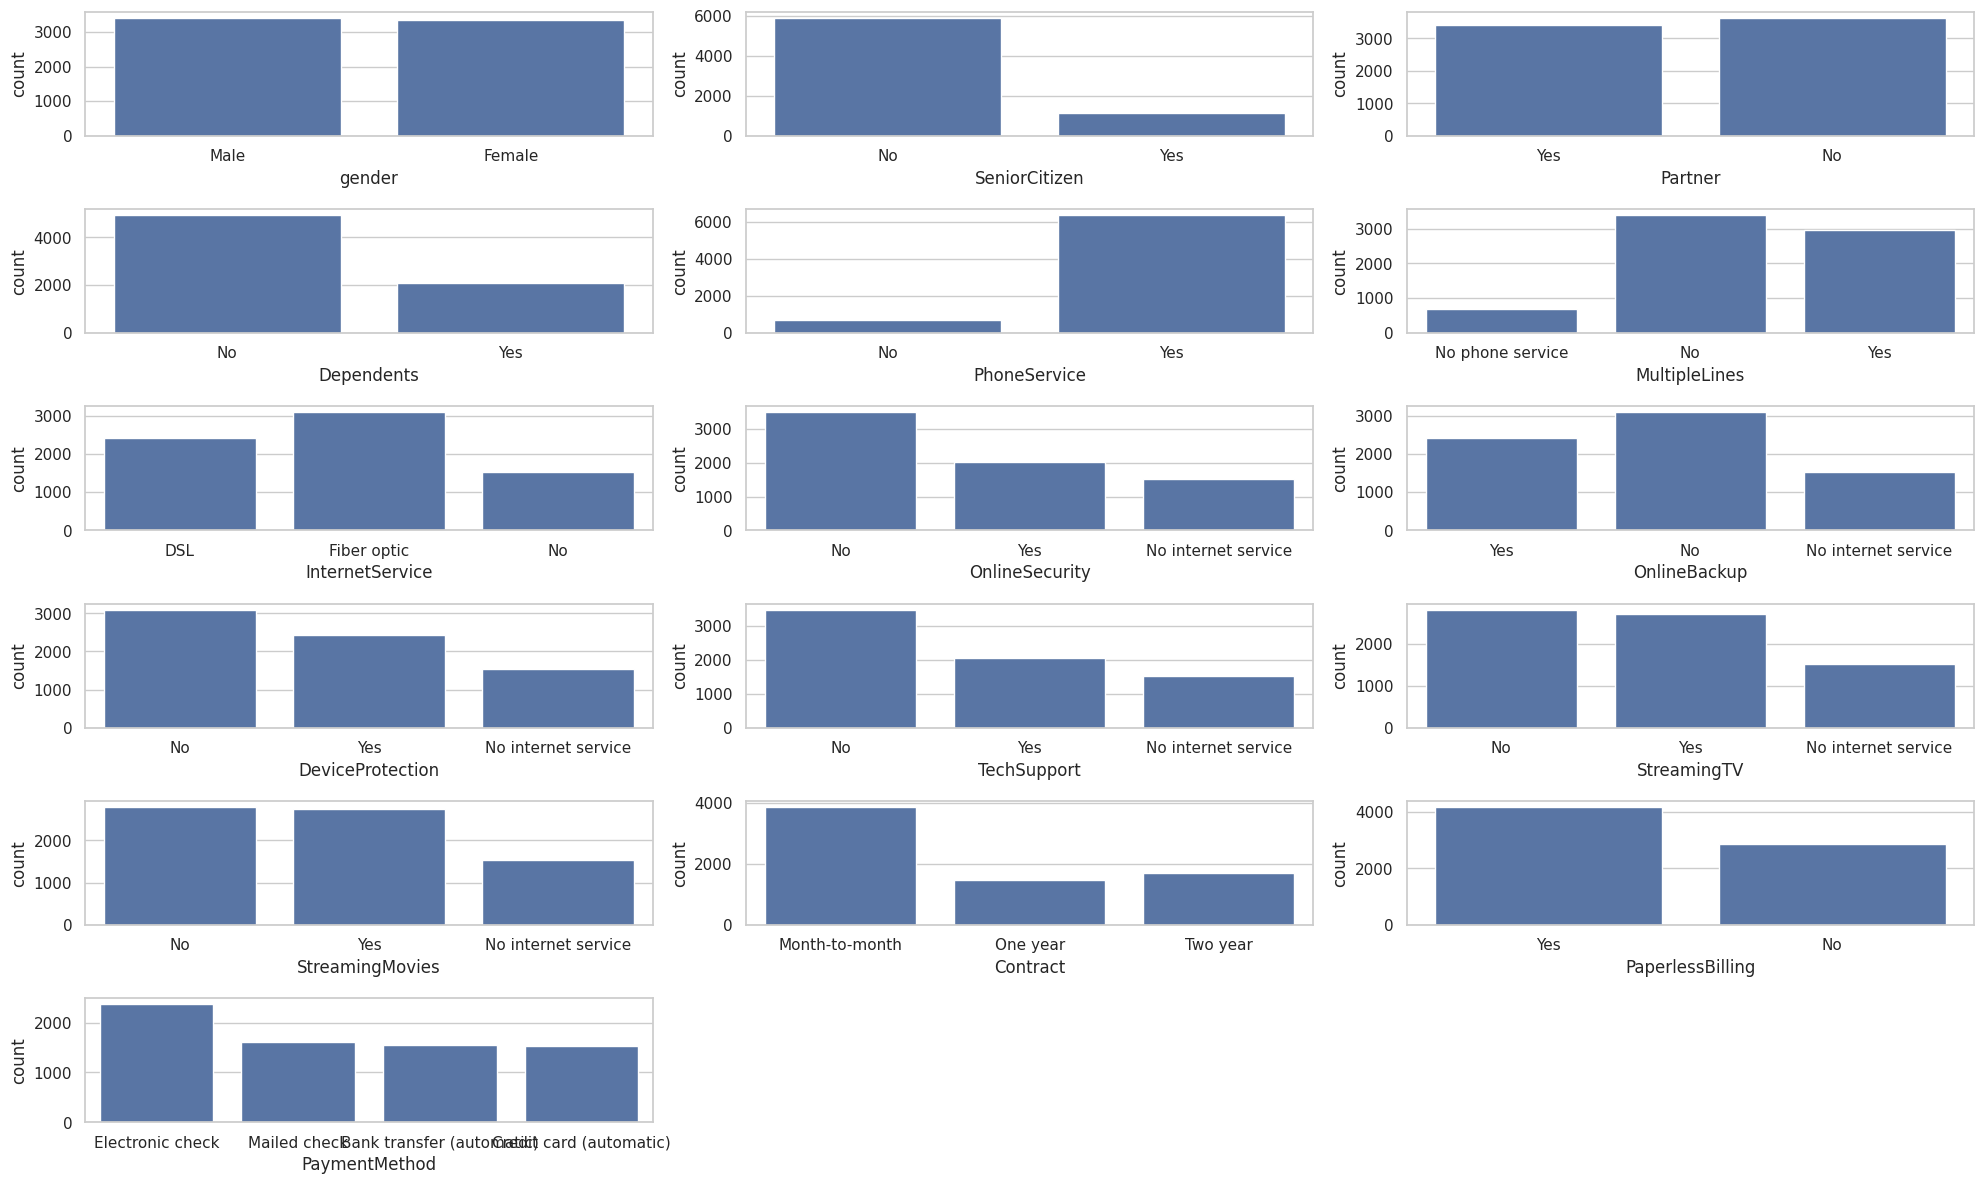

In [ ]:
# Chama a função para os atributos categóricos
count_plot(df,cat_cols)

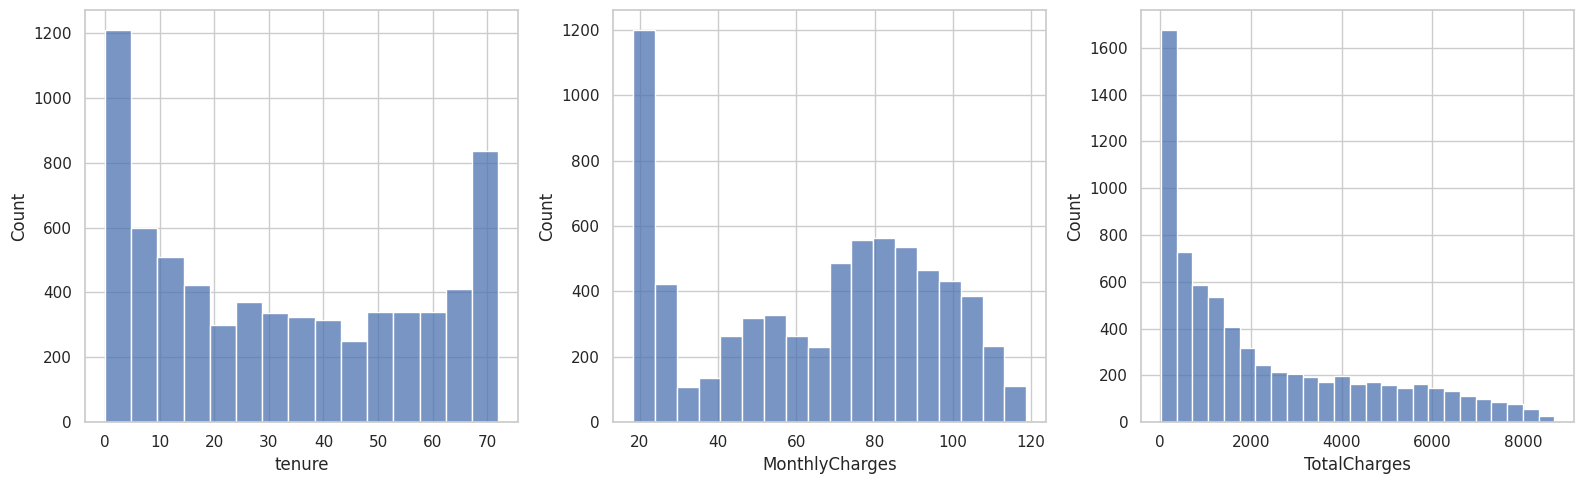

In [ ]:
# Chama a função para os atributos numéricos
dist_plot(df,num_cols,type="histogram")

In [ ]:
# Verifica se existem valores faltantes (missing)
df.isnull().sum()

## Criando conjuntos de treino e teste para avaliação de modelos


Antes de iniciar o treinamento do modelo, lembre-se que é recomendado sempre reservar uma porção dos dados para teste, a qual somente será utilizada para avaliação do modelo final (após todo o processo de treinamento e otimização de hiperparâmetros). Vamos fazer esta divisão, separando 20% para teste. Entretanto, primeiro precisamos dividir os dados entre atributos (X) e classe (y).


In [ ]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## Pré-processamento "Manual" (Sem Pipeline)

In [ ]:
# Imputadores e scaler
imputer = SimpleImputer(strategy='mean')
scaler = MinMaxScaler()

# Imputação
X_train_num = pd.DataFrame(imputer.fit_transform(X_train_raw[num_cols]), columns=num_cols)
X_test_num = pd.DataFrame(imputer.transform(X_test_raw[num_cols]), columns=num_cols)

# Codificação
X_train_cat = pd.get_dummies(X_train_raw[cat_cols], drop_first=True)
X_test_cat = pd.get_dummies(X_test_raw[cat_cols], drop_first=True)

# Alinhar colunas
X_train_cat, X_test_cat = X_train_cat.align(X_test_cat, join='left', axis=1, fill_value=0)

# Resetar os índices para evitar inserção de nulos
X_train_num.reset_index(drop=True, inplace=True)
X_test_num.reset_index(drop=True, inplace=True)
X_train_cat.reset_index(drop=True, inplace=True)
X_test_cat.reset_index(drop=True, inplace=True)

# Combinar os dados numéricos e categóricos
X_train_pp = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_pp = pd.concat([X_test_num, X_test_cat], axis=1)

# Normalização
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_pp), columns=X_train_pp.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_pp), columns=X_test_pp.columns)


In [ ]:
pd.DataFrame(X_train_num).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          4930 non-null   float64
 1   MonthlyCharges  4930 non-null   float64
 2   TotalCharges    4930 non-null   float64
dtypes: float64(3)
memory usage: 115.7 KB


In [ ]:
pd.DataFrame(X_train_cat).info()

<class 'pandas.core.frame.DataFrame'>
Index: 4930 entries, 5557 to 5639
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype
---  ------                                 --------------  -----
 0   gender_Male                            4930 non-null   bool 
 1   SeniorCitizen_Yes                      4930 non-null   bool 
 2   Partner_Yes                            4930 non-null   bool 
 3   Dependents_Yes                         4930 non-null   bool 
 4   PhoneService_Yes                       4930 non-null   bool 
 5   MultipleLines_No phone service         4930 non-null   bool 
 6   MultipleLines_Yes                      4930 non-null   bool 
 7   InternetService_Fiber optic            4930 non-null   bool 
 8   InternetService_No                     4930 non-null   bool 
 9   OnlineSecurity_No internet service     4930 non-null   bool 
 10  OnlineSecurity_Yes                     4930 non-null   bool 
 11  OnlineBackup_No internet service

## Treinamento Simples com KNN (Sem Pipeline)

Desempenho do modelo KNN (sem pipeline):
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1552
           1       0.53      0.52      0.52       561

    accuracy                           0.75      2113
   macro avg       0.68      0.68      0.68      2113
weighted avg       0.75      0.75      0.75      2113



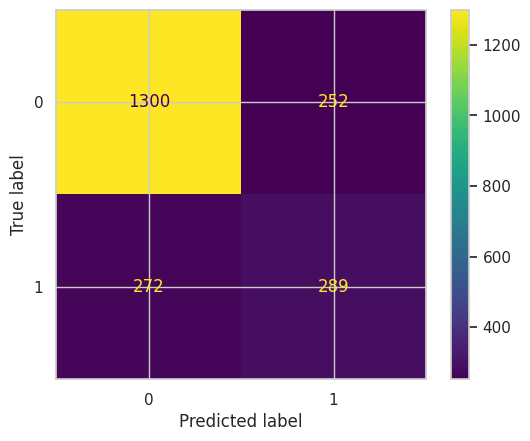

In [ ]:
clf_simple = KNeighborsClassifier(n_neighbors=5)
clf_simple.fit(X_train_scaled, y_train)
y_pred_simple = clf_simple.predict(X_test_scaled)

print("Desempenho do modelo KNN (sem pipeline):")
print(classification_report(y_test, y_pred_simple))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_simple)
plt.show()


## Pré-processamento e Otimização de Hiperparâmetros com Pipeline

Podemos (e devemos) usar um Nested Cross-Validation para realizar otimização de hiperparâmetros e análise de desempenho do modelo, conforme visto em aulas anteriores. Entretanto, o processo de Nested CV é mais custoso computacionalmente, demandando mais tempo. Assim, as células a seguir realização apenas um k-fold cross-validation simples com o intuito de comparar os desempenhos com e sem a aplicação de pipelines de pré-processamento, mantendo-se fixo o algoritmo de aprendizado supervisionado a ser usado. Entretanto, em projetos e aplicações reais, recomenda-se o uso de nested cross-validation para otimização dos modelos, conforme já foi discutido em aula.

Melhores hiperparâmetros: {'classifier__n_neighbors': 11}
Melhor Acurácia (validação cruzada): 0.5719545276292127

Desempenho final com Pipeline + GridSearchCV:
              precision    recall  f1-score   support

           0       0.91      0.65      0.76      1552
           1       0.46      0.82      0.59       561

    accuracy                           0.70      2113
   macro avg       0.68      0.73      0.67      2113
weighted avg       0.79      0.70      0.71      2113



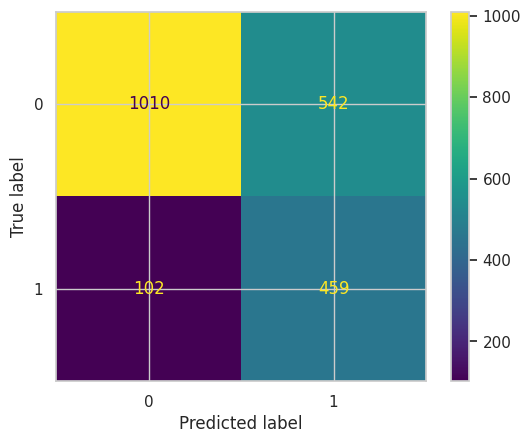

In [ ]:
# Pré-processamento com ColumnTransformer.
# Permite definir etapas distintas de pré-processamento para atributos categóricos e numéricos
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', MinMaxScaler())
    ]), num_cols),

    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]), cat_cols)
])

# Pipeline completo com SMOTE
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('balancer', SMOTE(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

# Grid de parâmetros
param_grid = {
    'classifier__n_neighbors': [3,5,7,9,11]}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid.fit(X_train_raw, y_train)

# Avaliação
print("Melhores hiperparâmetros:", grid.best_params_)
print("Melhor Acurácia (validação cruzada):", grid.best_score_)

y_pred_grid = grid.predict(X_test_raw)
print("\nDesempenho final com Pipeline + GridSearchCV:")
print(classification_report(y_test, y_pred_grid))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_grid)
plt.show()


# Comparando estratégias para lidar com desbalanceamento de classes


Os experimentos a seguir usarão valores pré-definidos de hiperparâmetros.
Usamos o KNN Imputer para dados numéricos e o SimpleImputer para dados categóricos. A avaliação dos modelos será feira com um RepeatedStratifiedKFold (3x5 repetições).

O primeiro treinamento do modelo com Pipeline não aplica estratégia para lidar com o desbalanceamento de classes. Os demais treinamentos usarão estratégias implementadas na biblioteca imblearn.

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1) ## usaremos o mesmo nas demais comparações

### Treinamento do modelo sem ajustar o balanceamento de classes

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder


## pipeline específico para os atributos numéricos
num_pipeline = Pipeline([
                        ('imputer', KNNImputer(weights="uniform"))])

## pipeline específico para os atributos categóricos
cat_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy='most_frequent')),
                         ('encoder', OneHotEncoder(drop='if_binary'))])

## ColumnTransformer para aplicar cada pipeline ao respectivo tipo de atributo
data_pipeline = ColumnTransformer([
                                   ('numerical', num_pipeline, num_cols),
                                   ('categorical', cat_pipeline, cat_cols)])

## pipeline que une as transformações definidas anteriormente e aplica a
## normalização em todos os atributos
my_pipeline = Pipeline([
                 ('data_transform', data_pipeline),
                 ('data_normalize',MinMaxScaler()),
                 ('classifier',KNeighborsClassifier(n_neighbors=11))])

## treina e avalia com cross-validation
scores = cross_val_score(my_pipeline, X_train_raw, y_train, scoring='f1', cv=cv, n_jobs=-1)

### Aplicando o método SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline


## pipeline específico para os atributos numéricos
num_pipeline = Pipeline([
    ('imputer', KNNImputer(weights="uniform"))])

## pipeline específico para os atributos categóricos
cat_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy='most_frequent')),
                         ('encoder', OneHotEncoder(drop='if_binary'))])

## ColumnTransformer para aplicar cada pipeline ao respectivo tipo de atributo
data_pipeline = ColumnTransformer([
                                   ('numerical', num_pipeline, num_cols),
                                   ('categorical', cat_pipeline, cat_cols)])



## pipeline que une as transformações definidas anteriormente e aplica a
## normalização em todos os atributos, seguida por SMOTE (oversampling)
my_pipeline2 = imbpipeline(steps = [['data_transform', data_pipeline],
                                    ['scaler', MinMaxScaler()],
                                    ['smote', SMOTE(sampling_strategy='auto',random_state=11)],
                                    ['classifier',KNeighborsClassifier(n_neighbors=11)]])

## treina e avalia com cross-validation
scores2 = cross_val_score(my_pipeline2, X_train_raw, y_train, scoring='f1', cv=cv, n_jobs=-1)

### Aplicando o método RandomUnderSampler

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

## pipeline específico para os atributos numéricos
num_pipeline = Pipeline([
    ('imputer', KNNImputer(weights="uniform"))])

## pipeline específico para os atributos categóricos
cat_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy='most_frequent')),
                         ('encoder', OneHotEncoder(drop='if_binary'))])

## ColumnTransformer para aplicar cada pipeline ao respectivo tipo de atributo
data_pipeline = ColumnTransformer([
                                   ('numerical', num_pipeline, num_cols),
                                   ('categorical', cat_pipeline, cat_cols)])


## pipeline que une as transformações definidas anteriormente e aplica a
## normalização em todos os atributos, seguida por undersampling
my_pipeline3 = imbpipeline(steps = [['data_transform', data_pipeline],
                                    ['scaler', MinMaxScaler()],
                                    ['under', RandomUnderSampler(random_state=11)],
                                    ['classifier',KNeighborsClassifier(n_neighbors=11)]])


## treina e avalia com cross-validation
scores3 = cross_val_score(my_pipeline3, X_train_raw, y_train, scoring='f1', cv=cv, n_jobs=-1)

### Aplicando o método SMOTE + TomekLinks

In [ ]:
from imblearn.combine import SMOTETomek

## pipeline específico para os atributos numéricos
num_pipeline = Pipeline([
    ('imputer', KNNImputer(weights="uniform"))])

## pipeline específico para os atributos categóricos
cat_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy='most_frequent')),
                         ('encoder', OneHotEncoder(drop='if_binary'))])

## ColumnTransformer para aplicar cada pipeline ao respectivo tipo de atributo
data_pipeline = ColumnTransformer([
                                   ('numerical', num_pipeline, num_cols),
                                   ('categorical', cat_pipeline, cat_cols)])



## pipeline que une as transformações definidas anteriormente e aplica a
## normalização em todos os atributos, seguida por SMOTE+TOMEK (over + undersampling)
my_pipeline4 = imbpipeline(steps = [['data_transform', data_pipeline],
                                    ['scaler', MinMaxScaler()],
                                    ['smotetomek', SMOTETomek(random_state=11)],
                                    ['classifier',KNeighborsClassifier(n_neighbors=11)]])


## treina e avalia com cross-validation
scores4 = cross_val_score(my_pipeline4, X_train_raw, y_train, scoring='f1', cv=cv, n_jobs=-1)

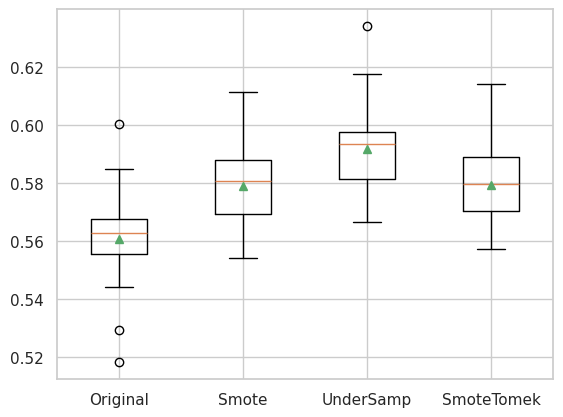

In [ ]:
results=[]
results.append(scores)
results.append(scores2)
results.append(scores3)
results.append(scores4)
plt.boxplot(results, labels=['Original','Smote','UnderSamp','SmoteTomek'], showmeans=True)
plt.show()

In [ ]:
## pipeline específico para os atributos numéricos
num_pipeline = Pipeline([
    ('imputer', KNNImputer(weights="uniform"))])

## pipeline específico para os atributos categóricos
cat_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy='most_frequent')),
                         ('encoder', OneHotEncoder(drop='if_binary'))])

## ColumnTransformer para aplicar cada pipeline ao respectivo tipo de atributo
data_pipeline = ColumnTransformer([
                                   ('numerical', num_pipeline, num_cols),
                                   ('categorical', cat_pipeline, cat_cols)])

## pipeline que une as transformações definidas anteriormente e aplica a
## normalização em todos os atributos
my_pipeline5 = Pipeline([
                 ('data_transform', data_pipeline),
                 ('data_normalize',MinMaxScaler()),
                 ['classifier',DecisionTreeClassifier(class_weight='balanced')]])


# Set of parameters for which to assess model performances
#param_grid = {'classifier__class_weight':[{0: w} for w in [0.01, 0.05, 0.1, 0.5, 1, 'balanced']]}
param_grid = {'classifier__class_weight':[{0: w} for w in [0.1, 0.5, 'balanced']]} ## simplificado

# avalia o pipeline

# define a estratégia de busca dos melhores hiperparâmetros
search = GridSearchCV(my_pipeline5, param_grid, scoring='f1', n_jobs=1, cv=cv, refit=True)

search.fit(X_train_raw, y_train)
scores5 = cross_val_score(my_pipeline5, X_train_raw, y_train, scoring='f1', cv=cv, n_jobs=-1)

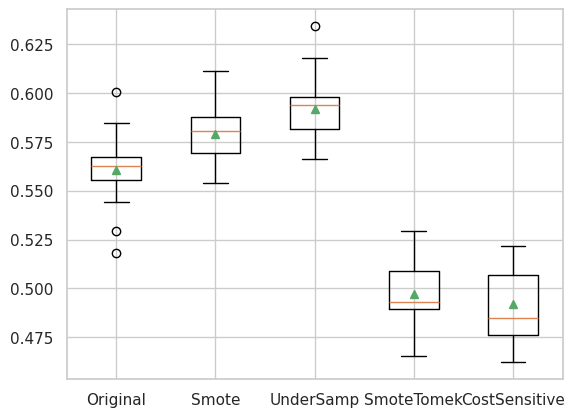

In [ ]:
results=[]
results.append(scores)
results.append(scores2)
results.append(scores3)
results.append(scores4)
results.append(scores5)
plt.boxplot(results, labels=['Original','Smote','UnderSamp','SmoteTomek','CostSensitive'], showmeans=True)
plt.show()

# Redução de Dimensionalidade
Nesta seção iremos observar o funcionamento do PCA e da Seleção de Atributos.



---



## Redução de dimensionalidade com PCA

In [ ]:

## pipeline específico para os atributos numéricos
num_pipeline = Pipeline([
                         ('imputer', KNNImputer(weights="uniform"))])

## pipeline específico para os atributos categóricos
cat_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy='most_frequent')),
                         ('encoder', OneHotEncoder(drop='if_binary'))])

## ColumnTransformer para aplicar cada pipeline ao respectivo tipo de atributo
data_pipeline = ColumnTransformer([
                                   ('numerical', num_pipeline, num_cols),
                                   ('categorical', cat_pipeline, cat_cols)])

## define pipeline que une as transformações definidas anteriormente e aplica a
## normalização com método MinMaxScaler() em todos os atributos
prep_pipeline = Pipeline([
                 ('data_transform', data_pipeline),
                 ('data_normalize',MinMaxScaler())])

## ajusta o pipeline a partir dos dados de treino, e na sequência aplica em
## treino e teste separadamente
prep_pipeline.fit(X_train_raw)
X_train_prep = prep_pipeline.transform(X_train_raw)
X_test_prep = prep_pipeline.transform(X_test_raw)

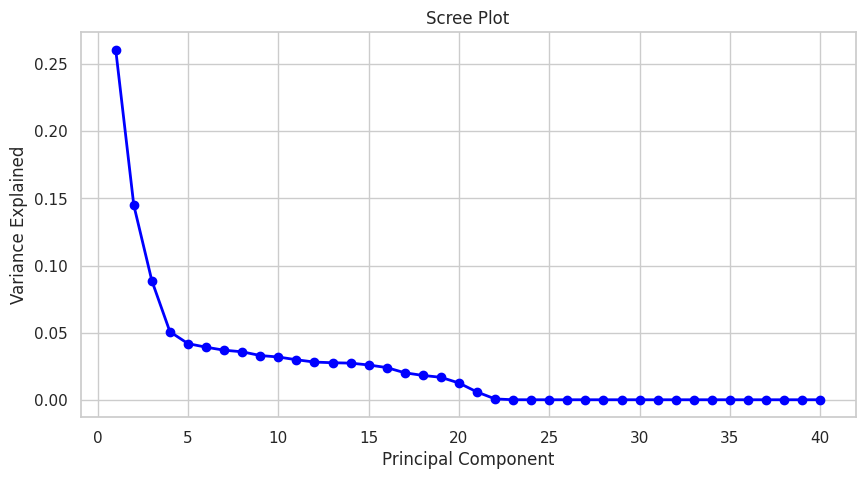

In [ ]:
from sklearn.decomposition import PCA

#define modelo PCA a usar, sem restringir número de componentes principais para manter
pca = PCA()

#ajusta o modelo PCA aos dados (sem modificar os dados)
pca.fit(X_train_prep)

plt.figure(figsize=(10, 5))
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [ ]:
# ajusta nome das columas e mostra dataframe após pré-processamento
columns = np.append(num_cols,prep_pipeline[0].named_transformers_['categorical']['encoder'].get_feature_names_out(cat_cols))
df_train_prep = pd.DataFrame(X_train_prep, columns=columns)
df_test_prep = pd.DataFrame(X_test_prep, columns=columns)

In [ ]:
df_train_prep

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,...,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.069444,0.615845,0.042165,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.041667,0.682113,0.023321,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.041667,0.565521,0.022837,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.833333,0.619332,0.557146,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.166667,0.802192,0.127176,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4925,0.875000,0.857997,0.758365,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4926,0.013889,0.327354,0.003739,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4927,0.986111,0.905331,0.887248,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4928,0.333333,0.019930,0.053537,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
## descomente se quiser observar os valores das variâncias das componentes 1-11
#print(pca.explained_variance_ratio_[0:10])

In [ ]:
## descomente se quiser observar os valores das variâncias cumulativas explicadas
## pelas componentes 1-11
#print(np.cumsum(pca.explained_variance_ratio_)[0:10])

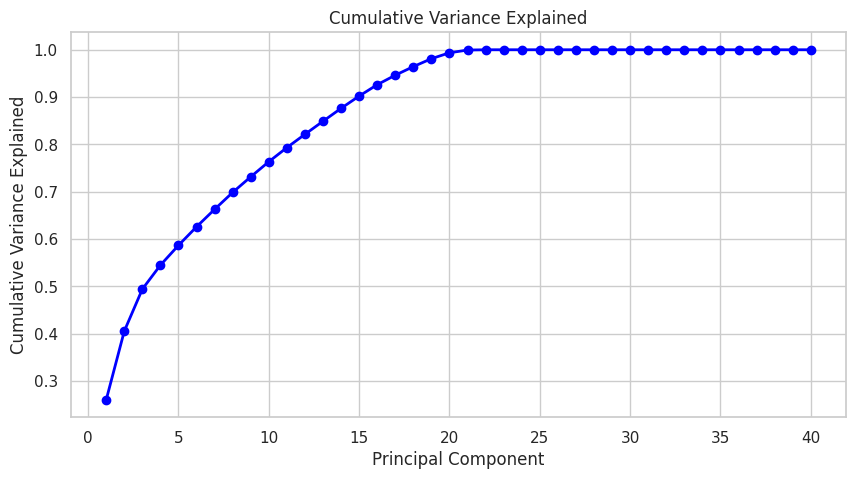

In [ ]:
plt.figure(figsize=(10, 5))
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, np.cumsum(pca.explained_variance_ratio_), 'o-', linewidth=2, color='blue')
plt.title('Cumulative Variance Explained')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Variance Explained')
plt.show()

In [ ]:
#projetando os dados de 40 dimensões para 2 (PC1 e PC2)
pca = PCA(2)
X_train_projected = pca.fit_transform(X_train_prep)
X_test_projected = pca.transform(X_test_prep)
print(X_train_prep.shape)
print(X_train_projected.shape)

(4930, 40)
(4930, 2)


Text(0, 0.5, 'component 2')

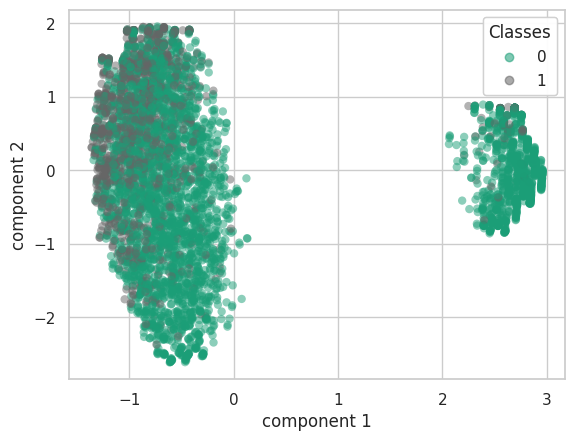

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(X_train_projected[:, 0], X_train_projected[:, 1],
            c=y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Dark2', 2))

legend1 = ax.legend(*scatter.legend_elements(),title="Classes")
ax.add_artist(legend1)

plt.xlabel('component 1')
plt.ylabel('component 2')


In [ ]:
loadings = pca.components_
num_pc = pca.n_features_in_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = df_train_prep.columns.values
loadings_df = loadings_df.set_index('variable')
#loadings_df #descomente se quiser visualizar os dados brutos

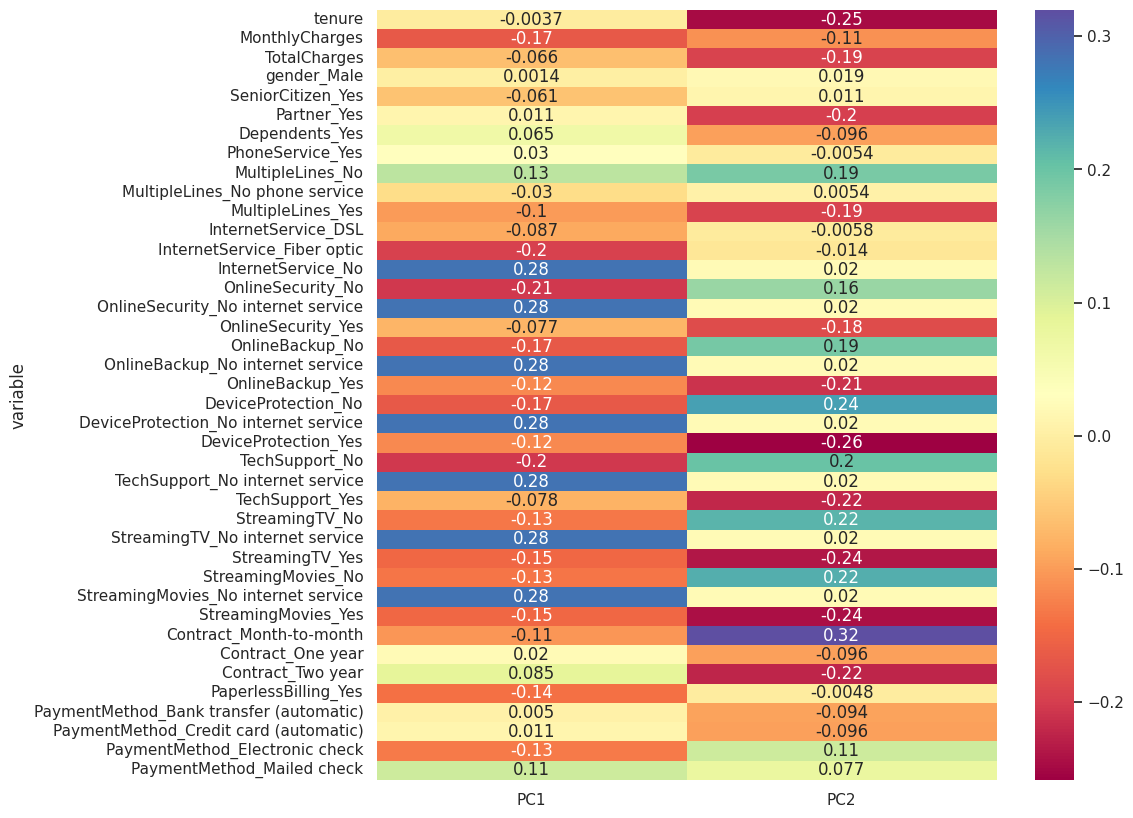

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()

In [ ]:
## treinando e avaliando com os dados originais
clf_original = KNeighborsClassifier(n_neighbors=11)
clf_original = clf_original.fit(X_train_prep,y_train)
clf_original_pred = clf_original.predict(X_test_prep)

## treinando e avaliando com duas componentes principais
clf_pca2 = KNeighborsClassifier(n_neighbors=11)
clf_pca2 = clf_pca2.fit(X_train_projected,y_train)
clf_pca2_pred = clf_pca2.predict(X_test_projected)

## fazendo a análise do PCA, extraindo 15 componentes principais
## usadas no treinamento e avaliação
pca15 = PCA(15)
X_train_projected15 = pca15.fit_transform(X_train_prep)
X_test_projected15 = pca15.transform(X_test_prep)
clf_pca15 = KNeighborsClassifier(n_neighbors=11)
clf_pca15 = clf_pca15.fit(X_train_projected15,y_train)
clf_pca15_pred = clf_pca15.predict(X_test_projected15)


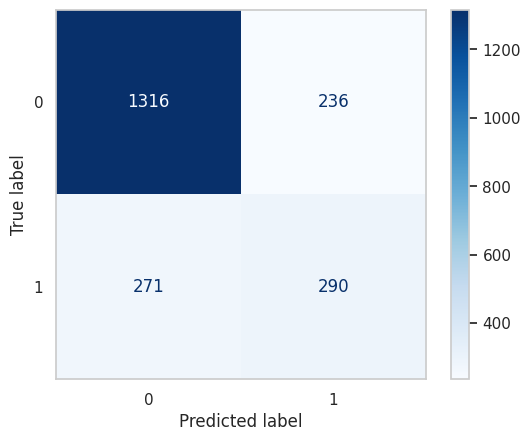

F1: 0.534
Recall: 0.517 
Precision: 0.551


In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score,f1_score,ConfusionMatrixDisplay

cm = confusion_matrix(y_test, clf_original_pred, labels=clf_original.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_original.classes_)
disp = disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')
plt.grid(False)
plt.show()
print("F1: {}".format(round(f1_score(y_test, clf_original_pred),3)))
print("Recall: {} ".format(round(recall_score(y_test, clf_original_pred),3)))
print("Precision: {}".format(round(precision_score(y_test, clf_original_pred),3)))

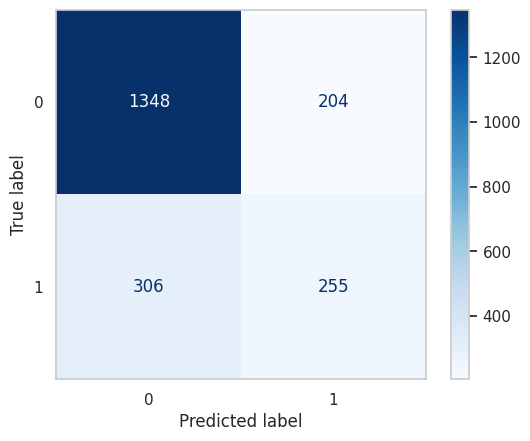

F1: 0.5
Recall: 0.455 
Precision: 0.556


In [ ]:
cm = confusion_matrix(y_test, clf_pca2_pred, labels=clf_original.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_original.classes_)
disp = disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')
plt.grid(False)
plt.show()
print("F1: {}".format(round(f1_score(y_test, clf_pca2_pred),3)))
print("Recall: {} ".format(round(recall_score(y_test, clf_pca2_pred),3)))
print("Precision: {}".format(round(precision_score(y_test, clf_pca2_pred),3)))

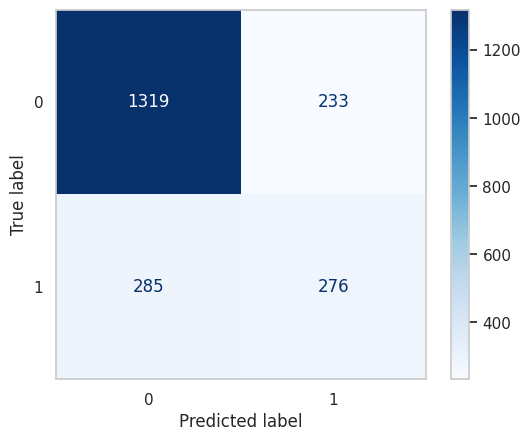

F1: 0.516
Recall: 0.492 
Precision: 0.542


In [ ]:
cm = confusion_matrix(y_test, clf_pca15_pred, labels=clf_pca15.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_pca15.classes_)
disp = disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')
plt.grid(False)
plt.show()
print("F1: {}".format(round(f1_score(y_test, clf_pca15_pred),3)))
print("Recall: {} ".format(round(recall_score(y_test, clf_pca15_pred),3)))
print("Precision: {}".format(round(precision_score(y_test, clf_pca15_pred),3)))



---



## Redução de dimensionalidade com seleção de atributos por Filtro

O módulo [sklearn.feature_selection](https://scikit-learn.org/stable/modules/feature_selection.html) possui uma série de funções para selecionar atributos, removendo aqueles que parecem não ser relevantes para uma determinada tarefa preditiva. As seções a seguir avaliam as estratégias baseadas em filtro usando o método SelectKBest(). Este método aplica um critério para ordenação dos atributos de acordo com sua relevância ou poder discriminativo e então retém apenas um subconjunto dos mais relevantes, de acordo com valor 'k' informado na chamada ao método.

Para classificação, o sklearn disponibiliza dois critérios para estimar importância de atributos: f_classif (baseado no ANOVA) e mutual_inf_classif (baseado na análise de informação mútua)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import f1_score

f_selected = list()
fs_perf = []
for ii in range(1, df_train_prep.shape[1]):
  fs = SelectKBest(score_func=f_classif, k=ii)
  X_train_fsc = fs.fit_transform(X_train_prep, y_train)
  X_test_fsc = fs.transform(X_test_prep)

  cols = fs.get_support(indices=True)
  f_selected.append((str(ii),columns[cols]))

  clf_fs = KNeighborsClassifier(n_neighbors=11)
  clf_fs = clf_fs.fit(X_train_fsc,y_train)
  clf_fs_pred = clf_fs.predict(X_test_fsc)

  fs_perf.append(round(f1_score(y_test, clf_fs_pred),3))

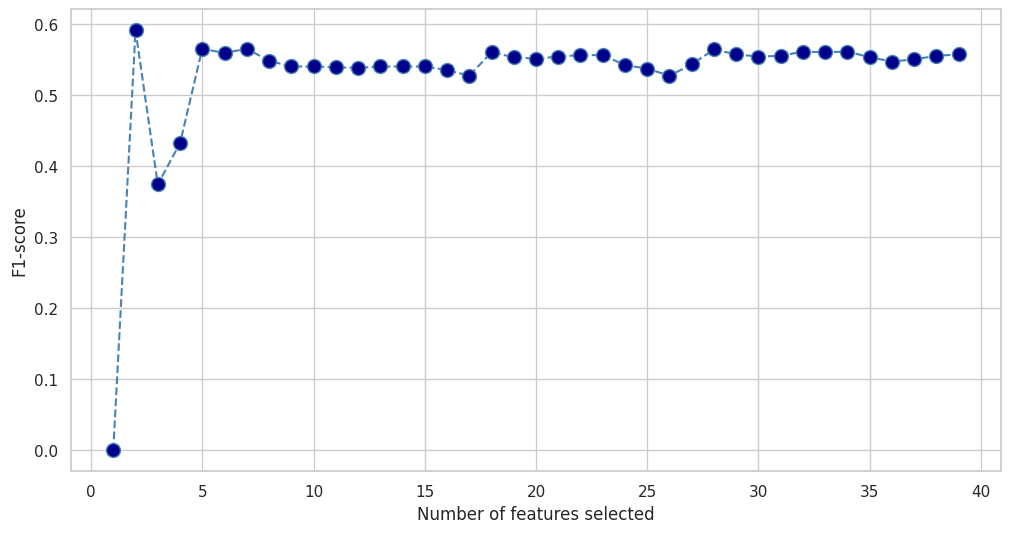

In [ ]:
plt.figure(figsize=(12, 6))
plt.xlabel("Number of features selected")
plt.ylabel("F1-score")
plt.plot(range(1,40), fs_perf, color='steelblue', linestyle='dashed', marker='o', markerfacecolor='darkblue', markersize=10)
plt.show()

In [ ]:
#print(f_selected[0][1])
print(f_selected[1][1])
#print(f_selected[2][1])
#print(f_selected[3][1])

['Contract_Month-to-month']
['OnlineSecurity_No' 'Contract_Month-to-month']




---



## Redução de dimensionalidade com seleção de atributos por métodos embedded

Alguns algoritmos de aprendizado de máquina são capazes de atribuir uma importância a cada atributo durante o processo de treinamento. No sklearn, estas informações estão normalmente nos atributos *coef_* ou *feature_importances_*.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

clf = RandomForestClassifier(n_estimators=50,random_state=42)
clf = clf.fit(X_train_prep, y_train)
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

Text(0, 0.5, 'Mean decrease in impurity')

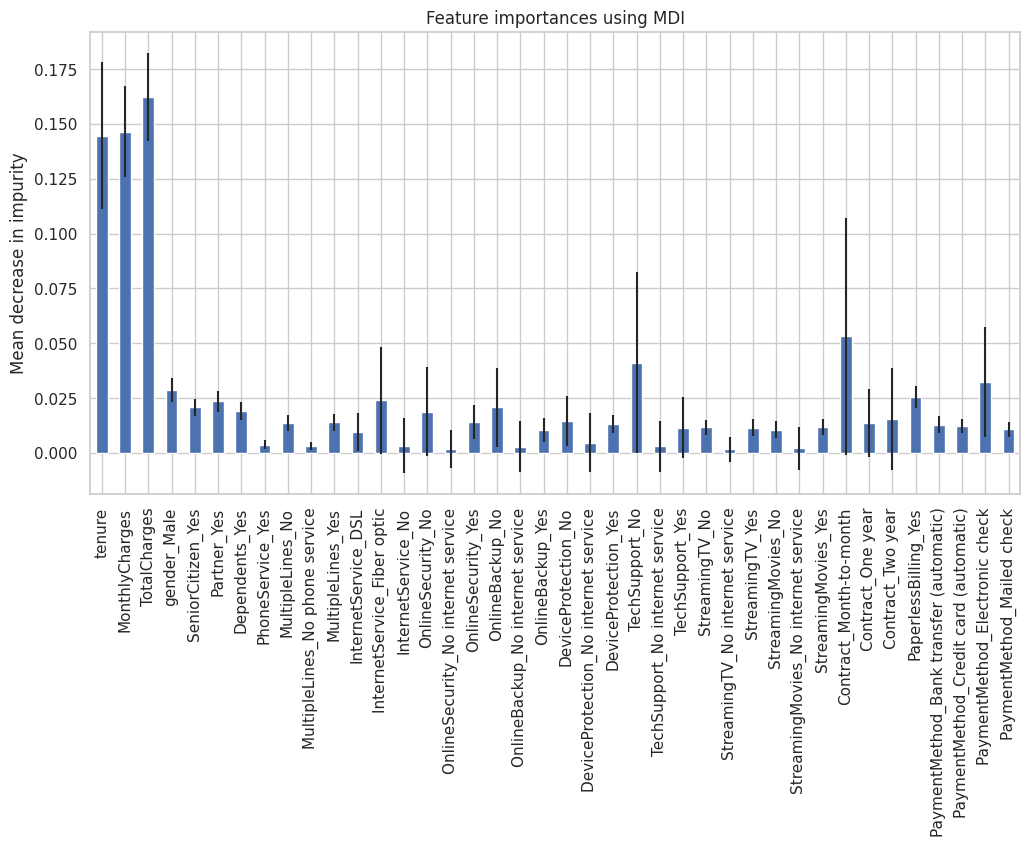

In [ ]:
forest_importances = pd.Series(clf.feature_importances_, index=columns)

fig, ax = plt.subplots(figsize=(12, 6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

Aplicando o método SelectFromModel sobre o Floresta Aleatória. Por padrão SelectFromModel selecionará os atributos cuja importância é maior que a importância média de todos os atributos.

In [ ]:
model = SelectFromModel(clf, prefit=True)
X_preproc_fs = model.transform(X_train_prep)

print(X_preproc_fs.shape[1])

8


In [ ]:
features_idx = model.get_support()
features_name = columns[features_idx]
print(features_name)

['tenure' 'MonthlyCharges' 'TotalCharges' 'gender_Male' 'TechSupport_No'
 'Contract_Month-to-month' 'PaperlessBilling_Yes'
 'PaymentMethod_Electronic check']




---



## Redução de dimensionalidade com seleção de atributos por métodos wrapper

O sklearn disponibiliza diferentes métodos de seleção de atributos por wrapper, incluindo o RFE. Além disso, a biblioteca fornece o método RFECV, que automaticamente determina o melhor tamanho de subconjunto de atributos para selecionar. A célula abaixo exemplifica o uso do RFECV.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

randomforest = RandomForestClassifier()
min_features_to_select = 1  # Número mínimo de atributos para considerar

## declara a estrutura do RFE-CV
rfecv = RFECV(
    estimator=randomforest,
    step=1,
    cv=StratifiedKFold(n_splits = 2), ## poucos splits para diminuir complexidade computacional
    scoring="f1",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train_prep, y_train)

RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(), scoring='f1')

In [ ]:
print("Número 'ótimo' de atributos : %d" % rfecv.n_features_)


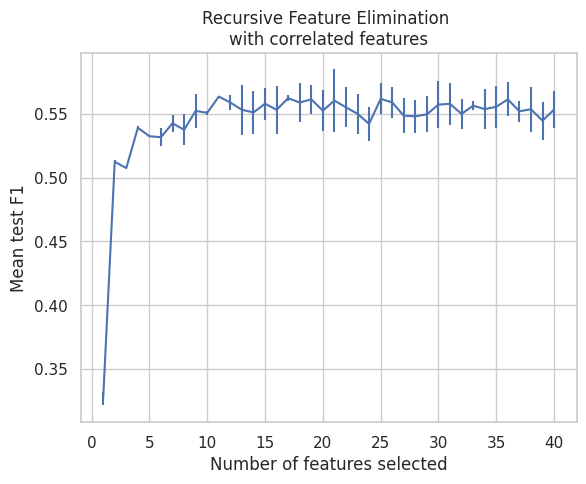

In [ ]:
cv_results = pd.DataFrame(rfecv.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test F1")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [ ]:
for i in range(X_train_prep.shape[1]):
	print('Column: %d (%s), Selected %s, Rank: %.3f' % (i, columns[i], rfecv.support_[i], rfecv.ranking_[i]))

Column: 0 (tenure), Selected True, Rank: 1.000
Column: 1 (MonthlyCharges), Selected True, Rank: 1.000
Column: 2 (TotalCharges), Selected True, Rank: 1.000
Column: 3 (gender_Male), Selected True, Rank: 1.000
Column: 4 (SeniorCitizen_Yes), Selected False, Rank: 5.000
Column: 5 (Partner_Yes), Selected False, Rank: 2.000
Column: 6 (Dependents_Yes), Selected False, Rank: 6.000
Column: 7 (PhoneService_Yes), Selected False, Rank: 26.000
Column: 8 (MultipleLines_No), Selected False, Rank: 4.000
Column: 9 (MultipleLines_No phone service), Selected False, Rank: 24.000
Column: 10 (MultipleLines_Yes), Selected False, Rank: 10.000
Column: 11 (InternetService_DSL), Selected False, Rank: 17.000
Column: 12 (InternetService_Fiber optic), Selected True, Rank: 1.000
Column: 13 (InternetService_No), Selected False, Rank: 28.000
Column: 14 (OnlineSecurity_No), Selected True, Rank: 1.000
Column: 15 (OnlineSecurity_No internet service), Selected False, Rank: 29.000
Column: 16 (OnlineSecurity_Yes), Selected F